# 分析内容
- 看NN和HH中N和H的差别
- 看LR之间的区别, 在NN和HH里
- 看NN和NH中的N的差别
- 看HH和NH中H的差别
- 看笼2和笼3之间的HH的差别
    - 评估不同限食组间的差别
- 在NN和HH中, 看前2h和后2h之间的差异
- 分别在前2h和后2h分析NN&NH(N)和HH&NH(H)
- 看食物的大小会不会对小鼠的进食行为产生影响, 在NN和HH中
- 看两天不同的NH中, N内是否有差异, H内是否有差异
- 数据中导入限食组的体重和与控制组的体重百分比
    - 既然有food结果, food可以代表其饥饿水平
    - 还是需要证据证明其饥饿水平和体重百分比存在关联
- 写代码整理每5分钟进食时间的数据
    - 次数无法在5分钟内得到合理的展示
- **写代码整理每10分钟进食时间的数据**
    - 批量改我的csv所有的label
    - 把这些数据画一下
- 处理新的HH和NH数据,看H的变化
- 处理新的NH数据,看和旧的NH中N的变化

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

from tqdm import tqdm
import os, re, time

In [53]:
#导入数据
from limeImport import getSQLTable
# 如需查看每列的数据类型，可将showSchema设为True
dataSheet = getSQLTable("summary", "data/chewing.db", showSchema=True) #summary数据 
weightSheet = getSQLTable("weight", "data/chewing.db", showSchema=True) #体重数据
#dataSheet.columns, weightSheet.columns

CREATE TABLE summary (
            SessionID       TEXT PRIMARY KEY NOT NULL,
            Setup           TEXT,
            Cage            INT,
            Mouse           TEXT,
            OppositeMouse   TEXT,
            Position        TEXT,
            PositionNum     INT,
            SessionDate     INT,
            StartTime       TEXT,
            Duration        REAL,
            AnalysisLength  TEXT,
            ChewCount       INT,
            ChewTime        REAL,
            ClimbCount      INT,
            ClimbTime       REAL,
            FoodBefore      REAL,
            FoodAfter       REAL,
            Food            REAL,
            Weight          REAL,
            setoff          REAL
        )
CREATE TABLE weight (
            Cage        INT,
            CageName    TEXT,
            Mouse       TEXT,
            SessionDate INT,
            Weight      REAL,
            Food        REAL
        )


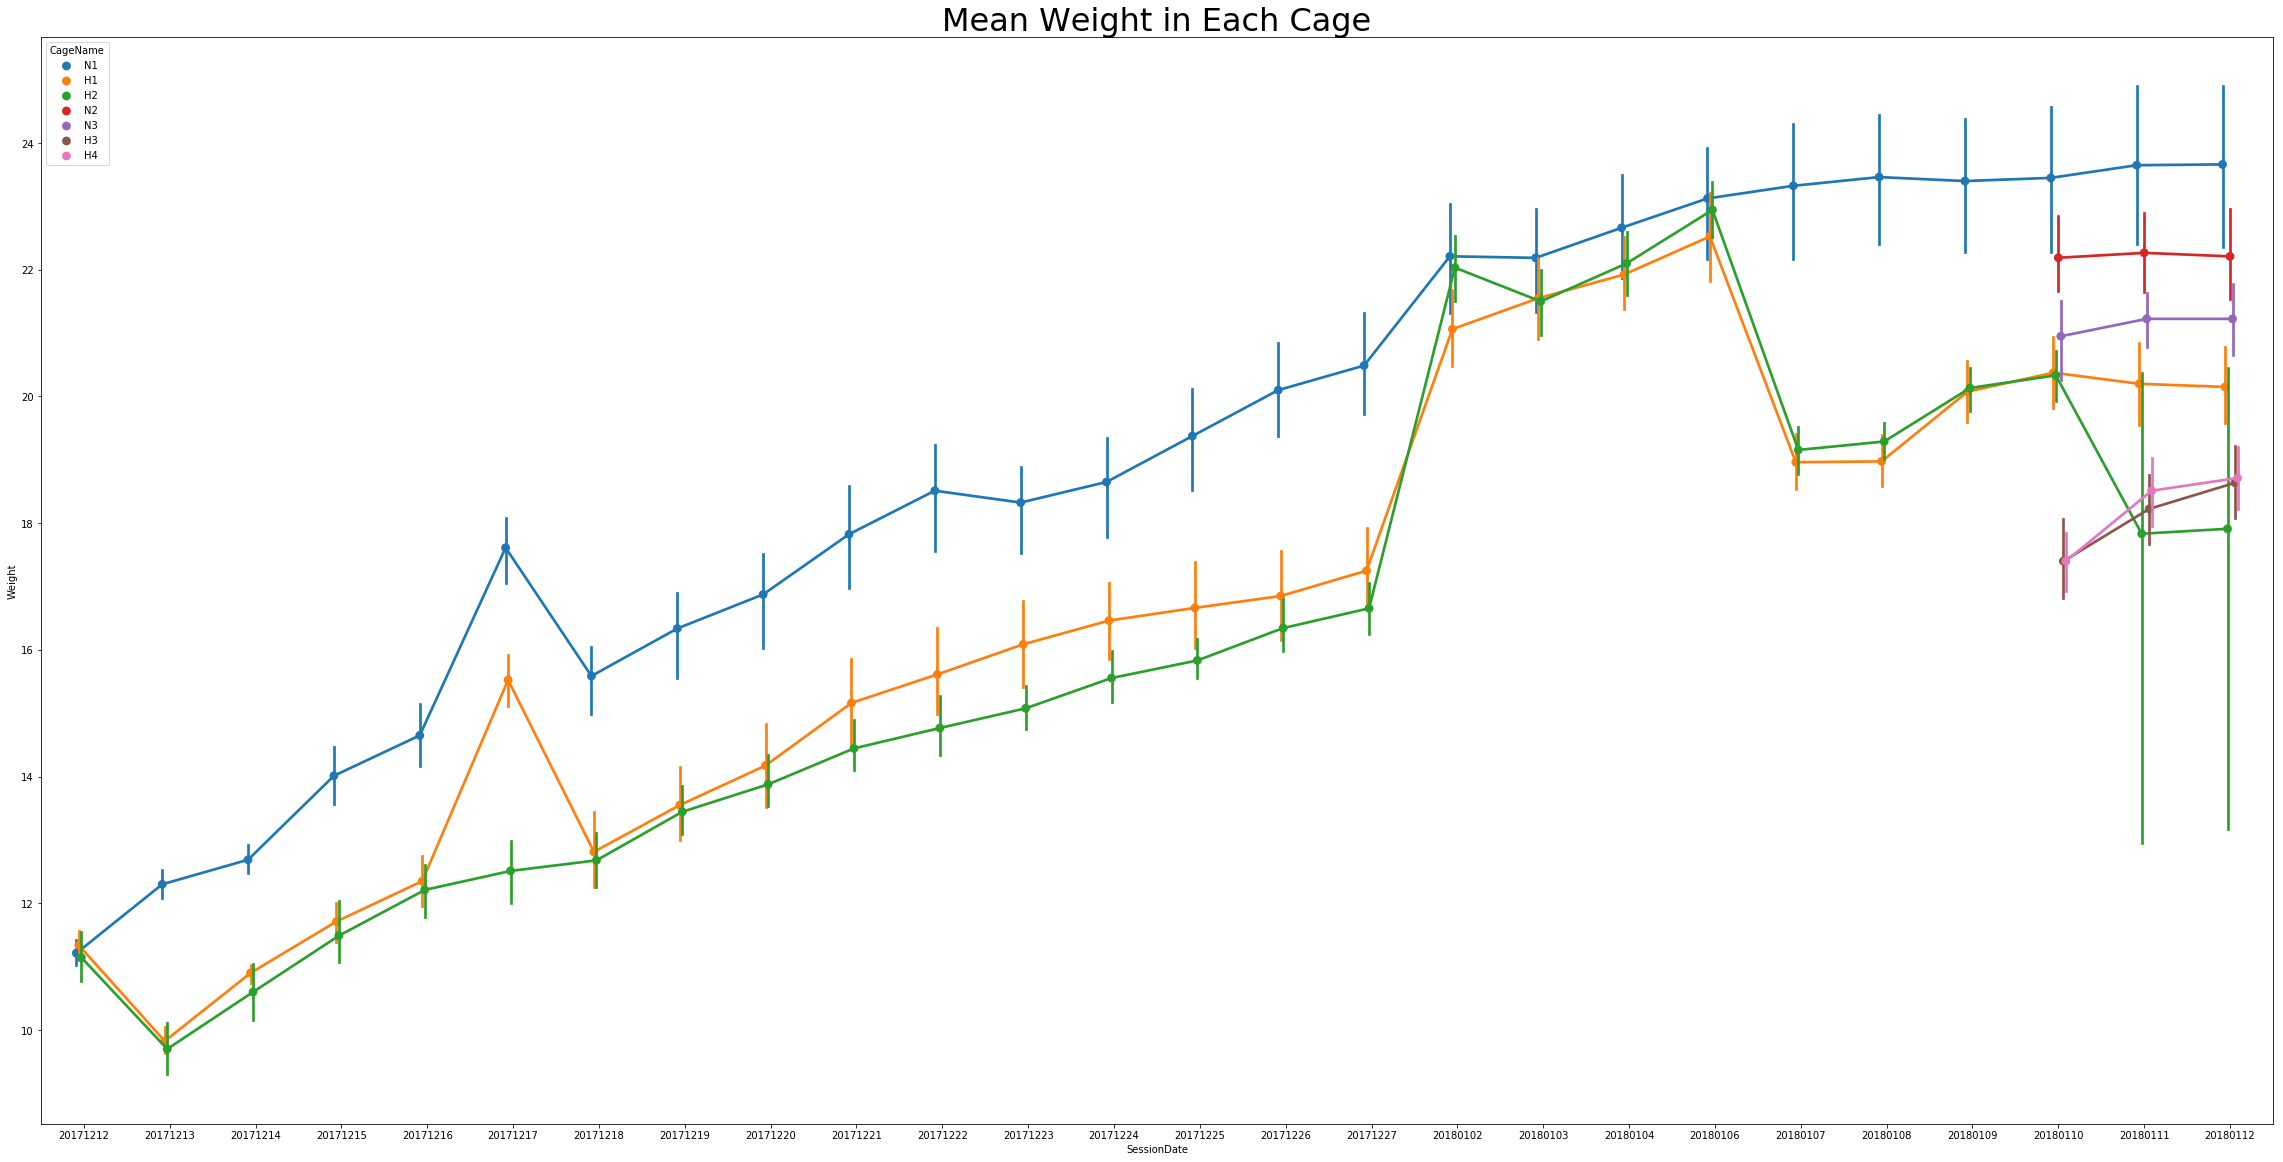

In [54]:
# weight information
plt.figure(figsize=(40,20))
sns.pointplot(data=weightSheet[weightSheet.SessionDate > 20170101],x='SessionDate',y='Weight',hue='CageName',dodge=True)
plt.title("Mean Weight in Each Cage", fontsize=32)
plt.show()

---
## NOTE:
绘图函数仍需要在实际数据下进一步完善。

In [3]:
# t-test
def ttest(sampleA, sampleB, isPaired=False):
    if type(sampleA) == type(sampleB) == type(np.array([])):
        pass
    else:
        sampleA = np.array(sampleA)
        sampleB = np.array(sampleB)

    if isPaired:
        sampleA = sampleA - sampleB
        sampleB = np.zeros(sampleA.size)
    
    return stats.ttest_ind(sampleA, sampleB)

In [11]:
# ploting

labelName = {
    'ChewCount':('Chew','Count'),
    'ClimbCount':('Climb','Count'),
    'ChewTime':('Chew','Time'),
    'ClimbTime':('Climb','Time'),
    'Food':('Food','Food'),
    'Weight':('Weight','Weight')
}

def singleplot(pos,data,xname,yname,title='p_paired=%f, p_2samp=%f', ci=95, axisfontsize=16):
    plt.subplot(*pos)
    sns.barplot(data=data,x=xname,y=yname,ci=ci)
    sns.stripplot(data=data,y=yname,x=xname,jitter=True,color='.5')
    plt.title(title)
    plt.ylabel(labelName[yname][1], fontsize=axisfontsize)
    plt.xlabel(labelName[yname][0], fontsize=axisfontsize)
    return

def compactplot(data,daterange=None,title='chart name', chartsize=6, seq=None):
    plt.figure(figsize=(chartsize*3,chartsize*2))
    plt.suptitle(title, fontsize=64)
    
    is seq == None:
        seq = [((2,3,1),'Cage','ChewCount'),((2,3,2),'Cage','ClimbCount'),((2,3,3),'Cage','Food'),
               ((2,3,4),'Cage','ChewTime'), ((2,3,5),'Cage','ClimbTime'), ((2,3,6),'Cage','Weight'),]
    cagePool = set(data['Cage'].values)
    
    for pos, xname, yname in seq:
        #TODO: Cage数超过2的处理
        samples = [testData[testData.Cage == item][yname].values for item in cagePool]
        p_paired = ttest(samples[0],samples[1],True)
        p_2samp = ttest(samples[0],samples[1])
    
        singleplot(pos, data, xname, yname,
                   title='p_paired=%f, p_2samp=%f'%(p_paired.pvalue,p_2samp.pvalue))

    return

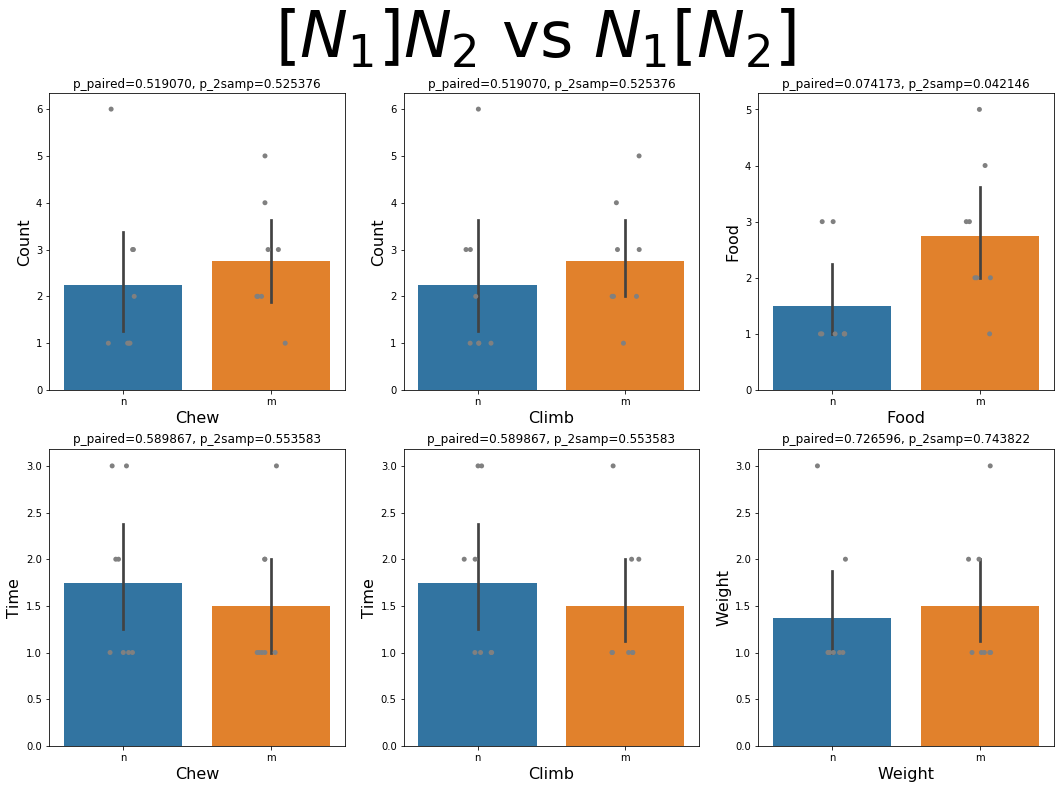

In [17]:
# demo
# test
testData = [['n',1,1,1,1,1,1],['m',1,1,1,1,1,1],['n',3,1,3,1,3,1],['m',2,1,2,1,2,1],
            ['n',6,2,6,2,1,1],['m',3,1,3,1,3,1],['n',1,2,1,2,1,2],['m',4,3,4,3,4,3],
            ['n',1,1,1,1,1,1],['m',2,2,2,2,2,2],['n',3,3,3,3,3,3],['m',2,1,2,1,2,1],
            ['n',2,3,2,3,1,1],['m',5,1,5,1,5,1],['n',1,1,1,1,1,1],['m',3,2,3,2,3,2]]
testData = pd.DataFrame(testData,columns=['Cage','ChewCount','ChewTime','ClimbCount','ClimbTime','Food','Weight'])

#示例
compactplot(testData,title='[$N_1$]$N_2$ vs $N_1$[$N_2$]')
plt.show()

---